In [1]:
import numpy as np
import torch
import gymnasium as gym
from matplotlib import pyplot as plt

import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
import random

In [2]:
env = gym.make("LunarLander-v2", continuous=False)

print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))
print("Reward range is {} ".format(env.reward_range))

Action space is Discrete(4) 
Observation space is Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32) 
Reward range is (-inf, inf) 


In [3]:


class ReinforceNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(ReinforceNetwork, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, n_outputs)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)
    
n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n
model = ReinforceNetwork(n_inputs, n_outputs)

print(model)

ReinforceNetwork(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


In [4]:
LEARNING_RATE = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [5]:
import matplotlib.pyplot as plt
from PIL import Image


def watch_agent(env, model):
    # reset the environment
    state, _ = env.reset()
    rewards = []
    images = []

    # T=2000 max
    for t in range(2000):
        # get predictions from the model and select the action according to probability distribution
        pred = model(torch.from_numpy(state).float())
        #action = np.random.choice(np.array([0,1]), p=pred.data.numpy())
        action = np.random.choice(np.arange(n_outputs), p=pred.data.numpy())


        # get image to export the video
        img = env.render()
        images.append(Image.fromarray(img))

        # execute action and get reward and new state
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        rewards.append(reward)

        if done:
            print("Reward:", sum([r for r in rewards]))
            break

    # duration is the number of milliseconds between frames; this is 40 frames per second
    images[0].save("video.gif", save_all=True, append_images=images[1:], duration=60, loop=0)
    
    # close Env
    env.close()

In [6]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")
watch_agent(env, model)

Reward: -53.26519532948667


### train the agent

In [7]:
HORIZON = 500
MAX_TRAJECTORIES = 5000
GAMMA = 0.99

score = []

In [8]:
for trajectory in range(MAX_TRAJECTORIES):
    current_state, _ = env.reset()
    done = False
    transitions = []

    # Run an entire episode (with maximum number of steps)
    for t in range(HORIZON):
        actions_prob = model(torch.from_numpy(current_state).float())
        #action = np.random.choice(np.array([0,1]), p=actions_prob.data.numpy())
        action = np.random.choice(np.arange(n_outputs), p=actions_prob.data.numpy())

        previous_state = current_state
        current_state, _, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        transitions.append((previous_state, action, t+1))
        if done:
            break

    score.append(len(transitions))
    reward_batch = torch.Tensor(np.array([r for (s,a,r) in transitions])).flip(dims=(0,))

    batch_Gvals = []
    for i in range(len(transitions)):
        new_Gval = 0
        power = 0
        for j in range(i, len(transitions)):
             new_Gval = new_Gval + ((GAMMA**power) * reward_batch[j]).numpy()
             power += 1

        batch_Gvals.append(new_Gval)

    expected_returns_batch = torch.FloatTensor(batch_Gvals)
    expected_returns_batch /= expected_returns_batch.max()

    state_batch = torch.Tensor(np.array([s for (s,a,r) in transitions]))
    action_batch = torch.Tensor(np.array([a for (s,a,r) in transitions]))

    predicted_batch = model(state_batch)
    prob_batch = predicted_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze()

    loss = - torch.sum(torch.log(prob_batch) * expected_returns_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if trajectory % 50 == 0 and trajectory>0:
        print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, np.mean(score[-50:-1])))

Trajectory 50	Average Score: 79.57
Trajectory 100	Average Score: 67.71
Trajectory 150	Average Score: 70.27
Trajectory 200	Average Score: 68.43
Trajectory 250	Average Score: 69.59
Trajectory 300	Average Score: 71.92
Trajectory 350	Average Score: 70.00
Trajectory 400	Average Score: 67.12
Trajectory 450	Average Score: 70.06
Trajectory 500	Average Score: 69.10
Trajectory 550	Average Score: 69.53
Trajectory 600	Average Score: 68.69
Trajectory 650	Average Score: 69.18
Trajectory 700	Average Score: 65.45
Trajectory 750	Average Score: 68.63
Trajectory 800	Average Score: 66.35
Trajectory 850	Average Score: 67.16
Trajectory 900	Average Score: 64.94
Trajectory 950	Average Score: 66.63
Trajectory 1000	Average Score: 67.22
Trajectory 1050	Average Score: 70.51
Trajectory 1100	Average Score: 64.06
Trajectory 1150	Average Score: 64.69
Trajectory 1200	Average Score: 69.69
Trajectory 1250	Average Score: 65.04
Trajectory 1300	Average Score: 67.29
Trajectory 1350	Average Score: 67.33
Trajectory 1400	Avera

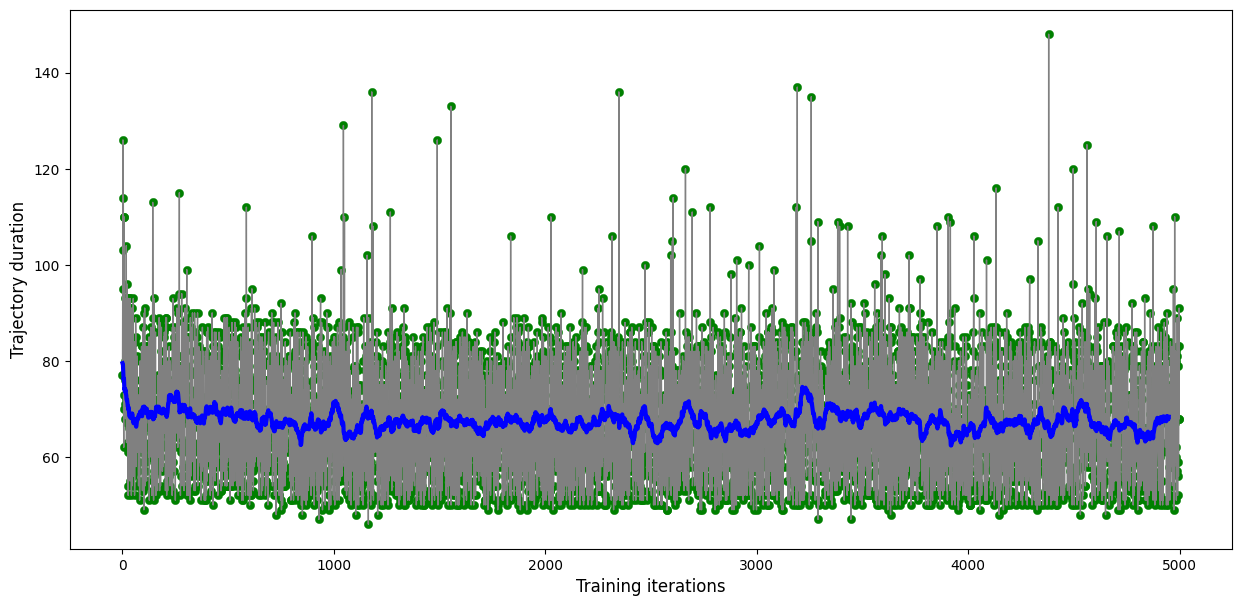

In [9]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory duration",fontsize=12)
plt.xlabel("Training iterations",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

In [10]:
watch_agent(env, model)

Reward: -365.9528747917934
